# Linear Regression by solving Normal Equations

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Load and Inspect Data

In [2]:
data = pd.read_csv("insurance.txt")
data.head(1)

,age,bmi,children,charges
0,19,27.9,0,16884.924


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   charges   1338 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 41.9 KB


In [4]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Preprocess Data

__The purpose of the following preprocessing is to demonstrate that the employed method is functioning correctly. However, while building regression models, the training and testing datasets are standardised separately to prevent data leakage.__

In [5]:
column_names = list(data.columns)
standardize = lambda x : (x - x.mean()) / x.std() 

__Standardize Data__

In [6]:
for column in column_names:
    data[column] = standardize(data[column])

In [7]:
data.mean()

age        -1.246304e-16
bmi        -1.810543e-16
children   -3.116590e-16
charges    -7.218939e-17
dtype: float64

Although standardised mean should be equal to 0, in reality they are infinitesimally close to zero. Double precision floats have 53 bits or 16 digits of precision, so this is expected behavior.

In [8]:
data.std()

age         1.0
bmi         1.0
children    1.0
charges     1.0
dtype: float64

In [9]:
x1, x2, x3, y = data["age"], data["bmi"], data["children"], data["charges"]

## Visualize Data

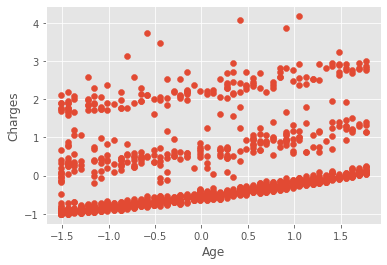

In [10]:
plt.scatter(x1, y)
plt.xlabel("Age")
plt.ylabel("Charges");

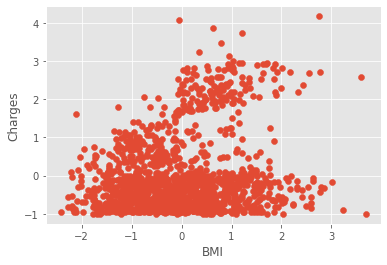

In [11]:
plt.scatter(x2, y)
plt.xlabel("BMI")
plt.ylabel("Charges");

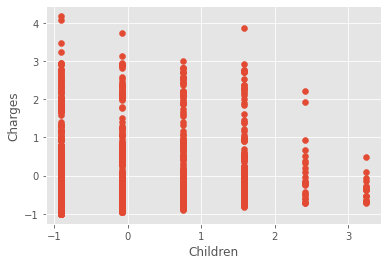

In [12]:
plt.scatter(x3, y)
plt.xlabel("Children")
plt.ylabel("Charges");

## Build Regression Models

$y = w_{0} + w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3}$

$x_{1}, x_{2}, x_{3}$ represent the age, bmi and number of children respectively. $ w_{1},w_{2}, w_{3}$ are weights associated with $x_{1}, x_{2}, x_{3}$.

$$X = 
\begin{bmatrix} 
1 & x_{11} & x_{12} & x_{13}\\
1 & x_{21} & x_{22} & x_{23}\\
. & . & . & . \\
. & . & . & . \\
1 & x_{m1} & x_{m2} & x_{m3}\\
\end{bmatrix}
\quad
$$
$$ $$
$$Y = 
\begin{bmatrix} 
y_{1}\\
y_{2}\\
.\\
.\\
y_{m}\\
\end{bmatrix}
\quad
$$ where $m$ = size of training data
$$ $$
$$ω = 
\begin{bmatrix} 
ω_{0}\\
ω_{1}\\
ω_{2}\\
ω_{3}\\
\end{bmatrix}
\quad
$$
$$ $$
$$b = X^{T} . Y$$

$$ ω = (X^{T}.X)^{-1}x^{T}.Y = (X^{T}.X)^{-1}.b$$

__Re-importing Unprocessed Data__

In [13]:
data = pd.read_csv("insurance.txt")
pd.options.mode.chained_assignment = None

In [14]:
class LinearRegressionNE:
    def __init__(self, data):
        self.data = data
        self.models = pd.DataFrame(columns = ["w0", "w1", "w2", "w3", "testing_error", "training_error"])
        self.model = np.zeros((4, 1))
        self.min_error = float("inf")
        self.buildModels()
    
    # shuffles data randomly
    def __shuffle(self):
        self.data = self.data.sample(frac = 1)
    
    # splits a data frame in 70:30 ratio
    def __split(self):
        train = self.data[:int(0.7 * len(data))]
        test = self.data[int(0.7 * len(data)):]
        return train, test
    
    # standardizes data
    def __standardize(self, data):
        column_names = list(data.columns)
        standardize = lambda x : (x - x.mean()) / x.std()
        for column in column_names:
            data[column] = standardize(data[column])
        return data
    
    # computes and returns X and Y matrices
    def __matrices(self, train):
        x1, x2, x3, y = train["age"], train["bmi"], train["children"], train["charges"]
        x1 = np.array(x1)
        x2 = np.array(x2)
        x3 = np.array(x3)
        Y = np.array(y)
        n = len(Y)
        Y = Y.reshape((n, 1))
        x0 = np.ones((n,1))
        x1 = np.reshape(x1, (n, 1))
        x2 = np.reshape(x2, (n, 1))
        x3 = np.reshape(x3, (n, 1))
        X = np.append(x0, x1, axis=1)
        X = np.append(X, x2, axis=1)
        X = np.append(X, x3, axis=1)
        return X, Y
    
    # calculates Mean Square Error
    def __error(self, X, Y, w):
        Y_pred = np.dot(X, w)
        mse = (1/2) * np.average((Y_pred-Y)**2)
        return float(mse)
    
    # tests the model against testing data
    def __testModel(self, test, w):
        Xt, Yt = self.__matrices(test)
        testing_error = self.__error(Xt, Yt, w)
        return testing_error
    
    # main function to build models
    def buildModels(self, number = 20):
        for i in range(number):
            # shuffle dataset
            self.__shuffle()
            # split dataset
            train, test = self.__split()
            # standardise training and testing data
            train = self.__standardize(train)
            test = self.__standardize(test)
            # obtain X and Y matrices
            X, Y = self.__matrices(train)
            # obtain the best-fit model weights
            w = self.__solve(X, Y)
            # calculate training error
            training_error = self.__error(X, Y, w)
            # calculate testing error
            testing_error = self.__testModel(test, w)
            # append the model, errors to models dataframe
            model = list(w)
            model.append(testing_error)
            model.append(training_error)
            model = pd.Series(model, index = self.models.columns)
            # the model with least testing error is accepted as the final model
            self.models = self.models.append(model, ignore_index=True)
            if self.min_error > testing_error:
                self.min_error = testing_error
                self.model = w

    #_____________________________________________________________________#           
    # solves normal equations and returns corresponding regression weights
    def __solve(self, X, Y):
        XT = np.transpose(X)
        A = XT.dot(X)
        A_inv = np.linalg.inv(A)
        b = XT.dot(Y)
        w = A_inv.dot(b)
        return w
    #_____________________________________________________________________#

__20 Linear Regression Models__

In [15]:
final_modelNE = LinearRegressionNE(data)
final_modelNE.models

,w0,w1,w2,w3,testing_error,training_error
0,[-1.6644339610682954e-16],[0.30129949645932597],[0.1854497737831175],[0.0255000465832643],0.467203,0.430174
1,[5.988829953248174e-18],[0.29127578548400374],[0.11995105299189263],[0.10411440370945722],0.449835,0.438739
2,[-7.609399595181167e-18],[0.2709194960989275],[0.1848947274916516],[0.03743922940994991],0.448474,0.437455
3,[-5.115373834742053e-17],[0.28240060717554044],[0.16864807667258386],[0.05059261791549355],0.444930,0.438049
4,[-2.3826735193306947e-17],[0.26721656696500345],[0.15546025211677567],[0.034344483822252],0.424080,0.447544
5,[-9.886033207740174e-17],[0.27146383358135473],[0.1814694164858694],[0.054279009259675735],0.441752,0.440187
6,[-4.564963432958722e-18],[0.2568817921535577],[0.17868026693902725],[0.06014338654004174],0.437467,0.442936
7,[-2.90676465521033e-17],[0.2908155440377612],[0.15202203292511085],[0.035871763193301175],0.449314,0.438379
8,[-2.7263416873878178e-17],[0.291309969094549],[0.16743002262202816],[0.09356400137541533],0.461902,0.433047
9,[-4.466863376730421e-17],[0.22153789021203274],[0.1924377735054202],[0.030571396807272753],0.421364,0.451258


$$Mean Square Error$$
$$
E(ω) = 
\begin{equation}
\frac{1}{2} * \frac{1}{N} * \sum_{n=0}^{N} (x_{n}*ω - y_{n})^{2} 
\end{equation}
$$


In [16]:
final_modelNE.models.describe()

,testing_error,training_error
count,20.000000,20.000000
mean,0.441408,0.440803
std,0.011714,0.005205
min,0.421364,0.430174
25%,0.434870,0.437900
50%,0.441360,0.440244
75%,0.448824,0.443478
max,0.467203,0.451258


In [17]:
print(f"Mean of testing error obtained over 20 regression models = {final_modelNE.models.testing_error.mean()}")

Mean of testing error obtained over 20 regression models = 0.44140832620071563


In [18]:
print(f"Variance of testing error obtained over 20 regression models = {final_modelNE.models.testing_error.var()}")

Variance of testing error obtained over 20 regression models = 0.00013720677321985494


In [19]:
print(f"Minimum testing error obtained over 20 regression models = {final_modelNE.models.testing_error.min()}")

Minimum testing error obtained over 20 regression models = 0.42136371863997374


In [20]:
print(f"Minimum training error obtained over 20 regression models = {final_modelNE.models.training_error.min()}")

Minimum training error obtained over 20 regression models = 0.4301738357582889


-------------------------------------------------------------------------------------------------------------------------------

# Linear Regression Gradient Descent

$$
E(ω) = 
\begin{equation}
\frac{1}{2} * \frac{1}{N} * \sum_{n=0}^{N} (x_{n}*ω - y_{n})^{2} 
\end{equation}
$$
$$ $$
$$ 
\begin{equation}
\frac{\partial E(ω)}{\partial ω} = \frac{1}{N}*(X.ω - Y).X
\end{equation}
$$
$$ $$
$$
ω = ω - η * \frac{\partial E(ω)}{\partial ω}
$$

In [21]:
data = pd.read_csv("insurance.txt")

In [22]:
class LinearRegressionGD:
    def __init__(self, data):
        self.data = data
        self.errors = []
        self.models = pd.DataFrame(columns = ["w0", "w1", "w2", "w3", "testing_error", "training_error", "iterations"])
    
    # shuffles data randomly
    def __shuffle(self):
        self.data = self.data.sample(frac = 1)
    
    # splits a data frame in 70:30 ratio
    def __split(self):
        train = self.data[:int(0.7 * len(data))]
        test = self.data[int(0.7 * len(data)):]
        return train, test
    
    # standardizes data
    def __standardize(self, data):
        column_names = list(data.columns)
        standardize = lambda x : (x - x.mean()) / x.std()
        for column in column_names:
            data[column] = standardize(data[column])
        return data
    
    # computes and returns X and Y matrices
    def __matrices(self, train):
        x1, x2, x3, y = train["age"], train["bmi"], train["children"], train["charges"]
        x1 = np.array(x1)
        x2 = np.array(x2)
        x3 = np.array(x3)
        Y = np.array(y)
        n = len(Y)
        Y = Y.reshape(n, 1)
        x0 = np.ones((n,1))
        x1 = np.reshape(x1, (n, 1))
        x2 = np.reshape(x2, (n, 1))
        x3 = np.reshape(x3, (n, 1))
        X = np.append(x0, x1, axis=1)
        X = np.append(X, x2, axis=1)
        X = np.append(X, x3, axis=1)
        return X, Y
    
    # calculates Mean Square Error
    def __error(self, X, Y, w):
        Y_pred = np.dot(X, w)
        mse = (1/2) * np.average((Y_pred-Y)**2)
        return float(mse)
    
    # tests the model against testing data
    def __testModel(self, test, w):
        Xt, Yt = self.__matrices(test)
        testing_error = self.__error(Xt, Yt, w)
        return testing_error
    
    # main function to build models
    def buildModels(self, number = 20):
        for i in range(number):
            # shuffle dataset
            self.__shuffle()
            # split dataset
            train, test = self.__split()
            # standardise training and testing data
            train = self.__standardize(train)
            test = self.__standardize(test)
            # obtain X and Y matrices
            X, Y = self.__matrices(train)
            # obtain the best-fit model weights
            w = np.random.rand(4, 1)
            w, model_errors , iterations = self.__gradientDescent(X, Y, w)
            # calculate training error
            training_error = self.__error(X, Y, w)
            # calculate testing error
            testing_error = self.__testModel(test, w)
            # append the model, errors to models dataframe
            model = list(w)
            model.append(testing_error)
            model.append(training_error)
            model.append(iterations)
            model = pd.Series(model, index = self.models.columns)
            # the model with least testing error is accepted as the final model
            self.models = self.models.append(model, ignore_index=True)
            self.errors.append(model_errors)
    #___________________________________________________________#
    # Implements Gradient Descent Algorithm
    def __gradientDescent(self, X, Y, w):
        learning_rate = 1e-5
        m, i = len(Y), 1
        errors = []
        error, prev_error = float("inf"), 0
        while abs(prev_error-error) > 1e-7:
            prev_error = error
            Y_pred = X.dot(w)
            gradient = (1/m) * np.dot(X.transpose(), Y_pred- Y)
            w -= learning_rate * gradient
            error = self.__error(X, Y, w)
            errors.append(error)
            i+=1
        return w, errors, i
    #___________________________________________________________#

In [23]:
final_modelGD = LinearRegressionGD(data)
final_modelGD.buildModels(20)

__20 Regression Models__

In [24]:
final_modelGD.models

,w0,w1,w2,w3,testing_error,training_error,iterations
0,[0.07893912497771075],[0.28467775962431874],[0.21627685507332164],[0.11739171141784059],0.454916,0.442253,229249
1,[0.05370040899436789],[0.31210728061363296],[0.2167446525809627],[0.08685863478152984],0.447536,0.441594,223853
2,[0.07271929191362236],[0.26384442044858125],[0.22185815793992933],[0.06224609694760765],0.435386,0.446819,232910
3,[0.03876987362195896],[0.26190596752466644],[0.25983802064954703],[0.09187365871626806],0.444287,0.445358,204873
4,[0.06790669437351542],[0.2862773112059406],[0.21770511414411522],[0.1281924330073985],0.482974,0.430330,268767
5,[0.07489020072511432],[0.2967146228275708],[0.23555636609612488],[0.09861733781789452],0.456185,0.442382,227689
6,[0.07952759558361834],[0.25874232043219014],[0.20890973808217972],[0.13065103897950847],0.464885,0.439234,175454
7,[0.05519978447709493],[0.3081249471081407],[0.2157660875427068],[0.14772950212923766],0.475614,0.436070,210525
8,[0.0539184460366949],[0.23913676577671183],[0.2460343854084339],[0.1054196727808764],0.442462,0.447364,194213
9,[0.08308200477564905],[0.3271603264027193],[0.2156021432600069],[0.03273835489634159],0.457961,0.440530,225362


__Plotting the Convergence__

Plot $E(\omega)$ against the number of iterations of gradient descent

In [26]:
errors = np.array(final_modelGD.errors, dtype=object)

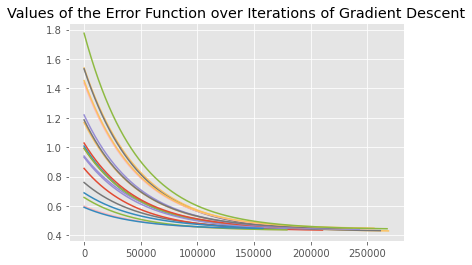

In [27]:
for error in errors:
    plt.plot(error)
    plt.title("Values of the Error Function over Iterations of Gradient Descent");

In [28]:
final_modelGD.models.describe()

,testing_error,training_error
count,20.000000,20.000000
mean,0.453520,0.442397
std,0.014794,0.005275
min,0.432304,0.430330
25%,0.443384,0.440206
50%,0.451226,0.442431
75%,0.459692,0.446895
max,0.482974,0.448920


In [29]:
print(f"Mean of testing error obtained over 20 regression models = {final_modelGD.models.testing_error.mean()}")

Mean of testing error obtained over 20 regression models = 0.45352021088400835


In [30]:
print(f"Variance of testing error obtained over 20 regression models = {final_modelGD.models.testing_error.var()}")

Variance of testing error obtained over 20 regression models = 0.0002188487900490819


In [31]:
print(f"Mean of training error obtained over 20 regression models = {final_modelGD.models.training_error.mean()}")

Mean of training error obtained over 20 regression models = 0.44239677433398966


In [32]:
print(f"Variance of training error obtained over 20 regression models = {final_modelGD.models.training_error.var()}")

Variance of training error obtained over 20 regression models = 2.7822123785268208e-05
